In [35]:
from pymongo import MongoClient
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import functions.count_categories
import functions.count_offices
import functions.us_state_code

# Loading the data...
### This data has been acquired from crunch database with the following proposes:
- #### Analyze where the most valuable companies are located (city, country).
- #### Calculate how many offices they have and scan where they are located.
- #### Have a look of the category of those companies and count them by region.

In [36]:
client = MongoClient()
db = client.companies

-----
## This first query is carried out in order to filter the most valuable companies in the dataset (1M companies). Also, it's important to see how the data is structured

In [37]:
filt = {'ipo.valuation_amount':{'$gt':1_000_000}}
project = {
    'name':1,
    'category_code':1,
    'number_of_employees':1,
    'founded_year':1,
    'total_money_raised':1,
    'ipo.valuation_amount':1,
    'offices':1
}

co_1M = db.companies.find(filt, project)
list(co_1M)[0]['category_code']

'social'

## In order to have a better understanding, let's see what the maximum number of offices per 1M company

In [38]:
filt = {'ipo.valuation_amount':{'$gt':1_000_000}}
project = {
    'name':1,
    'category_code':1,
    'offices':1
}

office_count = db.companies.find(filt, project)

In [39]:
office_count_list = list(office_count)

### There are 59 companies in the database that are valued at 1M USD or more

In [40]:
len(office_count_list)

59

### The following function counts the number of offices per company, and return a dictionary with the following format:
- #### { 'company_name_1' : number_of_offices, 'company_name_2' : number_of_offices, ... }

In [41]:
functions.count_offices.count_offices(office_count_list)

{'Facebook': 3,
 'Twitter': 1,
 'Yelp': 1,
 'LinkedIn': 1,
 'Amazon': 1,
 'Brightcove': 7,
 'KIT digital': 10,
 'JumpTV': 1,
 'Nielsen': 1,
 'OpenTable': 1,
 'ChannelAdvisor': 1,
 'Jive Software': 5,
 'Zillow': 1,
 'Wix': 2,
 'Vringo': 1,
 'Shutterfly': 1,
 'TripAdvisor': 1,
 'Salesforce': 1,
 'HomeAway': 1,
 'DivX': 1,
 'QuinStreet': 1,
 'Rackspace': 3,
 'BMC Software': 1,
 'Higher One': 1,
 'Infoblox': 1,
 'Tencent': 1,
 'Marketo': 1,
 'Baidu': 1,
 'Geeknet': 5,
 'Opsware': 1,
 'Telenav': 6,
 'Rally Software': 9,
 'BrightSource Energy': 1,
 'Mixi': 1,
 'QlikTech': 2,
 'Pironet': 0,
 'Inuvo': 1,
 'Chegg': 1,
 'Groupon': 4,
 'RPX Corporation': 1,
 'SolarWinds': 1,
 'GREE': 1,
 'Meru Networks': 1,
 'Tudou': 1,
 'DemandTec': 2,
 'Cornerstone OnDemand': 1,
 'Western Digital': 1,
 'Millennial Media': 1,
 'Real Goods Solar': 5,
 'GT Solar': 4,
 'EnerNOC': 1,
 'STR': 1,
 'Global Water': 1,
 'Emdeon': 1,
 'Energy and Power Solutions': 1,
 'Elster Group': 1}

### Additionally, it could be interesting to count the category ('category_code') associated with each company.

In [42]:
dic_category = functions.count_categories.count_categories(office_count_list)

In [43]:
df_category = pd.DataFrame(list(dic_category.items()),
                       columns=['category_code', 'count'],
                       index=[i for i in range(len(dic_category))])

df_category.sort_values('count', ascending=False, inplace=True)

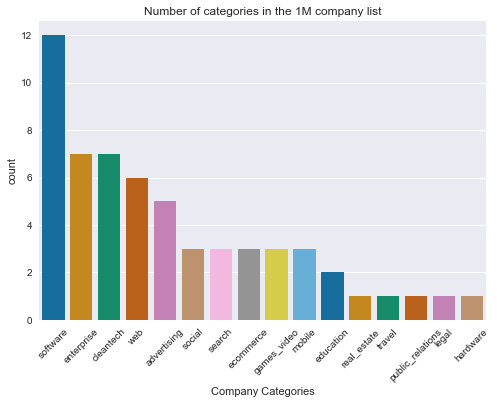

In [44]:
plt.style.use('seaborn')
sns.barplot(x='category_code', y='count',
            data=df_category, palette='colorblind')
plt.title('Number of categories in the 1M company list')
plt.xlabel('Company Categories')
plt.xticks(rotation=45)
plt.show()

---
## Beacuse in the next phase of this study I'd like to use geojson and filter the 1M-companies by region, let's split each document by office

In [45]:
res = db.companies.aggregate([
                      {"$unwind":"$offices" },
                      {"$match":{"offices.latitude":{"$ne":None}}},
                      {"$match":{"offices.longitude":{"$ne":None}}},
                      {"$project":{"_id":0}}
                     ])

In [46]:
db.companies_unwinded.insert_many(res)

In [47]:
db.list_collection_names()

['searched_places', 'companies', 'companies_unwinded']

In [48]:
offices = db.companies_unwinded

In [49]:
# filt = {'$or': [{'ipo.valuation_amount':{'$gt':1_000_000}},
#                {'category_code': 'design'}]
#        }
# project = {
#     'name':1,
#     'category_code':1,
#     'number_of_employees':1,
#     'founded_year':1,
#     'total_money_raised':1,
#     'ipo.valuation_amount':1,
#     'offices':1
# }
data = offices.find({})

## Normalizing coordinates as geojson.
### This will be important and necessary to filter by location and mark some offices of interest in maps.

In [50]:
for office in data:
    filt = {"_id":office["_id"]}
    coord = {
              "type": "Point",
              "coordinates": [office["offices"]["longitude"],
                              office["offices"]["latitude"]]
            }
    update = {"$set":{"coord":coord}}
    offices.update_one(filt,update)

## Locating the most 1M-company offices by region

In [51]:
filt = {'ipo.valuation_amount':{'$gt':1_000_000}}
project = {
    'name':1,
    'category_code':1,
    'number_of_employees':1,
    'founded_year':1,
    'total_money_raised':1,
    'ipo.valuation_amount':1,
    'offices':1
}

offices_1M = offices.find(filt, project)

In [52]:
df_offices_1M = pd.json_normalize(offices_1M)

In [53]:
# city, state, country, ipo, total_money, founded_year, number_of _employees, category_code

In [54]:
df_offices_1M.columns

Index(['_id', 'name', 'category_code', 'number_of_employees', 'founded_year',
       'total_money_raised', 'offices.description', 'offices.address1',
       'offices.address2', 'offices.zip_code', 'offices.city',
       'offices.state_code', 'offices.country_code', 'offices.latitude',
       'offices.longitude', 'ipo.valuation_amount'],
      dtype='object')

In [55]:
df_offices_1M['offices.country_code'].value_counts()

USA    219
GBR     10
CAN      5
ANT      5
SWE      5
IRL      5
CHN      5
Name: offices.country_code, dtype: int64

In [56]:
country_percentage = df_offices_1M['offices.country_code'].value_counts() / df_offices_1M['offices.country_code'].count() * 100

 - ### 86% of the 1M-company offices in the dataset are located in USA
 - ### 10% of them are located in North Europe

In [57]:
country_percentage

USA    86.220472
GBR     3.937008
CAN     1.968504
ANT     1.968504
SWE     1.968504
IRL     1.968504
CHN     1.968504
Name: offices.country_code, dtype: float64

<AxesSubplot:ylabel='offices.country_code'>

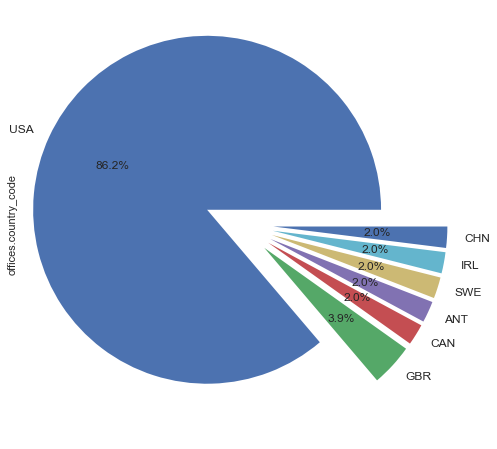

In [58]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot()
country_percentage.plot(kind='pie', y=country_percentage,
                        autopct='%1.1f%%', ax=ax1,
                        explode=[.2 for _ in range(len(country_percentage))],
                        legend=False,
                        fontsize=12)

In [59]:
us_offices = df_offices_1M[df_offices_1M['offices.country_code'] == 'USA']

In [60]:
us_offices_serie = us_offices['offices.state_code'].value_counts()
us_offices_serie = us_offices_serie.reset_index()
us_offices_serie = us_offices_serie.rename(columns={'index':'state'})
us_offices_serie['state'] = us_offices_serie['state'].apply(
    lambda x: functions.us_state_code.abbrev_us_state[x]
)

In [61]:
us_offices_serie

,state,offices.state_code
0,California,94
1,New York,25
2,Massachusetts,15
3,Connecticut,10
4,Colorado,10
5,Texas,10
6,Washington,10
7,Florida,10
8,Arizona,5
9,New Hampshire,5


- ### Almost 42% of the 1M-company offices in USA are located in California

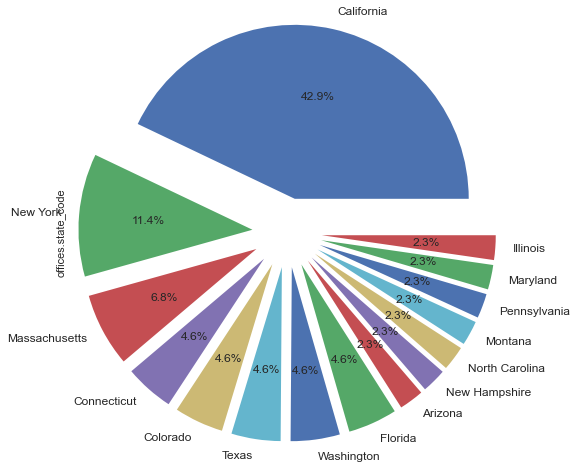

In [62]:
plt.figure(figsize=(16,8))
ax1 = plt.subplot()
us_offices_serie.plot(kind='pie', y='offices.state_code',
                      autopct='%1.1f%%', ax=ax1,
                      explode=[.2 for _ in range(len(us_offices_serie['state']))],
                      labels=us_offices_serie['state'],
                      legend=False,
                      fontsize=12)
plt.show()

## US cities where 1M-company offices are located

In [63]:
city_serie = us_offices[['offices.city', 'offices.state_code']]
city_serie = city_serie.value_counts()
df_city = city_serie.to_frame(name='count').reset_index()

In [64]:
df_city['offices.state_code'] = df_city['offices.state_code'].apply(
    lambda x: functions.us_state_code.abbrev_us_state[x]
)

In [65]:
df_city

,offices.city,offices.state_code,count
0,New York,New York,25
1,San Francisco,California,20
2,Seattle,Washington,10
3,Santa Clara,California,10
4,Clearwater,Florida,10
5,Sunnyvale,California,5
6,Foster City,California,5
7,Merrimack,New Hampshire,5
8,Louisville,Colorado,5
9,Houston,Texas,5


In [66]:
df_city.sort_values(by='offices.state_code', inplace=True)

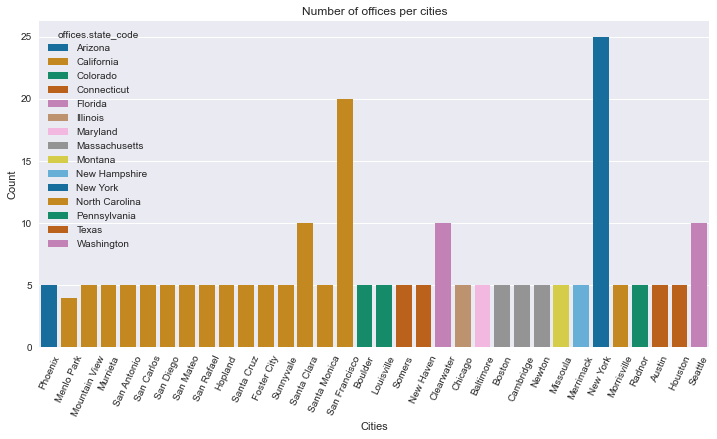

In [67]:
plt.figure(figsize=(12,6))
sns.barplot(x='offices.city', y='count', data=df_city,
            hue='offices.state_code', dodge=False,
            palette='colorblind', )
plt.title('Number of offices per cities')
plt.xlabel('Cities')
plt.ylabel('Count')
plt.xticks(rotation=65)
plt.show()

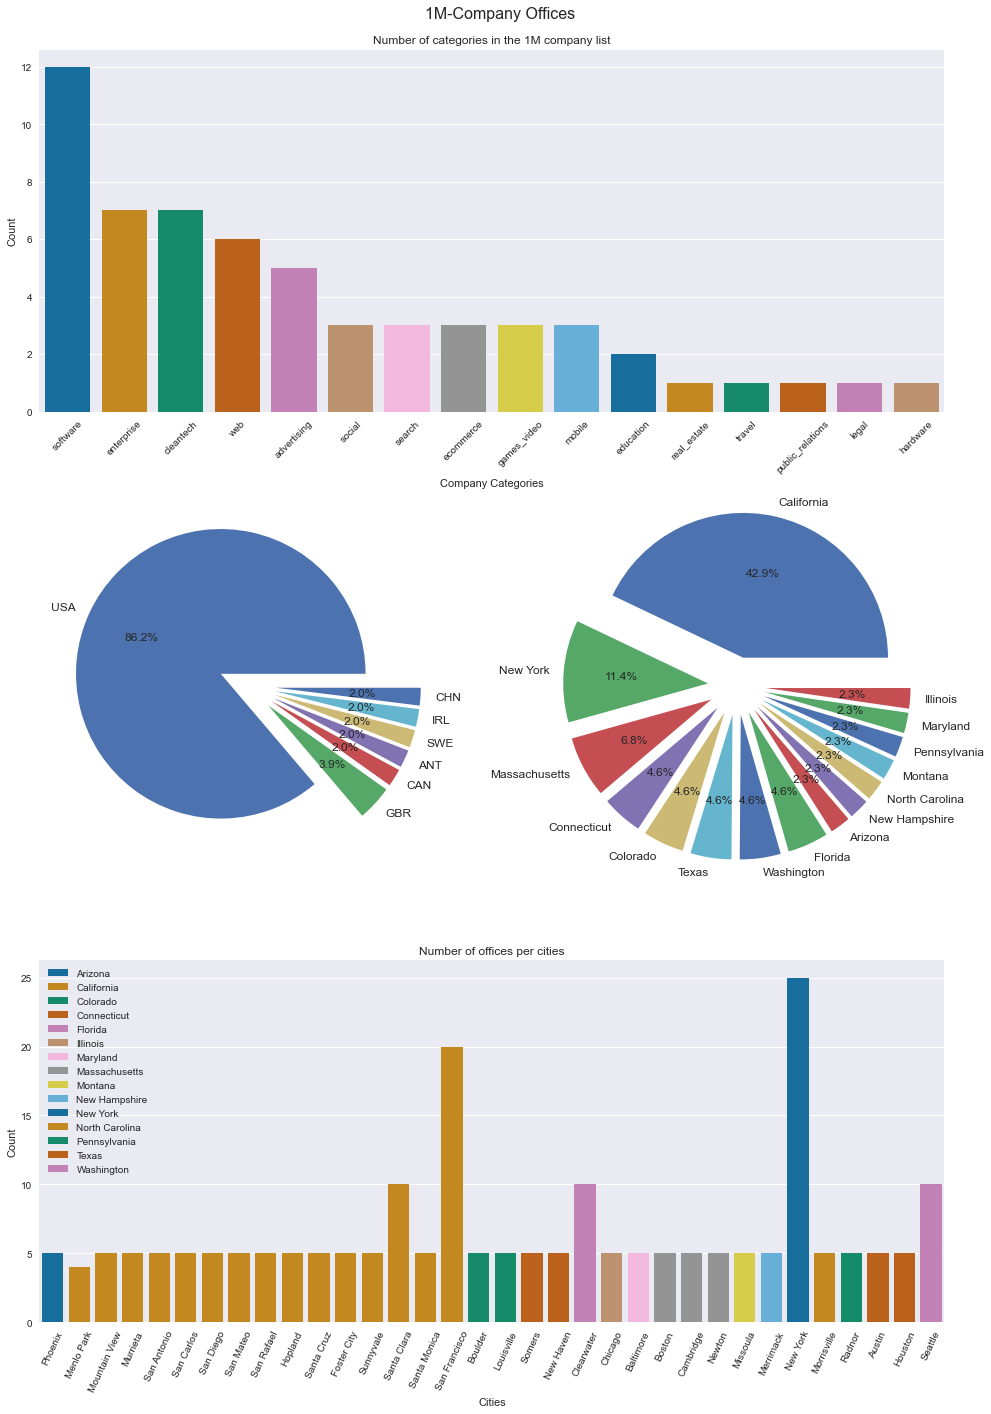

In [68]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(14,20))
fig.suptitle('1M-Company Offices', fontsize=16)

plt.subplot(3,1,1)
sns.barplot(x='category_code', y='count',
            data=df_category, palette='colorblind')
plt.title('Number of categories in the 1M company list')
plt.xlabel('Company Categories')
plt.ylabel('Count')
plt.xticks(rotation=45)


ax1 = plt.subplot(3,2,3)
country_percentage.plot(kind='pie', y=country_percentage,
                        autopct='%1.1f%%', ax=ax1,
                        explode=[.2 for _ in range(len(country_percentage))],
                        legend=False, ylabel='',
                        fontsize=12)


ax2 = plt.subplot(3,2,4)
us_offices_serie.plot(kind='pie', y='offices.state_code',
                      autopct='%1.1f%%', ax=ax2,
                      explode=[.2 for _ in range(len(us_offices_serie['state']))],
                      labels=us_offices_serie['state'],
                      legend=False, ylabel='',
                      fontsize=12)


plt.subplot(3,1,3)
sns.barplot(x='offices.city', y='count', data=df_city,
            hue='offices.state_code', dodge=False,
            palette='colorblind', )
plt.legend(loc='upper left')
plt.title('Number of offices per cities')
plt.xlabel('Cities')
plt.ylabel('Count')
plt.xticks(rotation=65)

fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.savefig('../outputs/1m-company-offices-chart.png')

plt.show()